# Data fetching

In [ ]:
import sys
assert sys.version_info >= (3, 7)

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
import re

import joblib

In [ ]:
def load_data(path,url):
  FPath=Path(path)
  if not FPath.is_file():
    Path("datasets").mkdir(parents=True,exist_ok=True)
    urllib.request.urlretrieve(url,FPath)
    with tarfile.open(FPath) as data_tarball:
      data_tarball.extractall(path="datasets")
  return pd.read_csv(Path("/content/datasets/titanic/train.csv"))

In [ ]:
Training_data=load_data("datasets/titanic.tgz","https://homl.info/titanic.tgz")

/tmp/ipython-input-1040399222.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  data_tarball.extractall(path="datasets")


In [ ]:
Test_data=pd.read_csv(Path("/content/datasets/titanic/test.csv"))

# age training data collect

In [ ]:
FullData=pd.concat([Training_data,Test_data])
FullData.count()

,0
PassengerId,1309
Survived,891
Pclass,1309
Name,1309
Sex,1309
Age,1046
SibSp,1309
Parch,1309
Ticket,1309
Fare,1308


In [ ]:
FullData.reset_index(drop=True,inplace=True)

In [ ]:
FullData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [ ]:
FullData_copy=FullData.drop(['Survived','Cabin'],axis=1)

In [ ]:
FullData_copy.count()

,0
PassengerId,1309
Pclass,1309
Name,1309
Sex,1309
Age,1046
SibSp,1309
Parch,1309
Ticket,1309
Fare,1308
Embarked,1307


In [ ]:
to_pred_AGE=FullData_copy.loc[FullData['Age'].isna()]

In [ ]:
To_Fit_AGE=FullData_copy.dropna(subset=['Age'])

In [ ]:
to_pred_AGE.count()

,0
PassengerId,263
Pclass,263
Name,263
Sex,263
Age,0
SibSp,263
Parch,263
Ticket,263
Fare,263
Embarked,263


In [ ]:
To_Fit_AGE.count()

,0
PassengerId,1046
Pclass,1046
Name,1046
Sex,1046
Age,1046
SibSp,1046
Parch,1046
Ticket,1046
Fare,1045
Embarked,1044


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

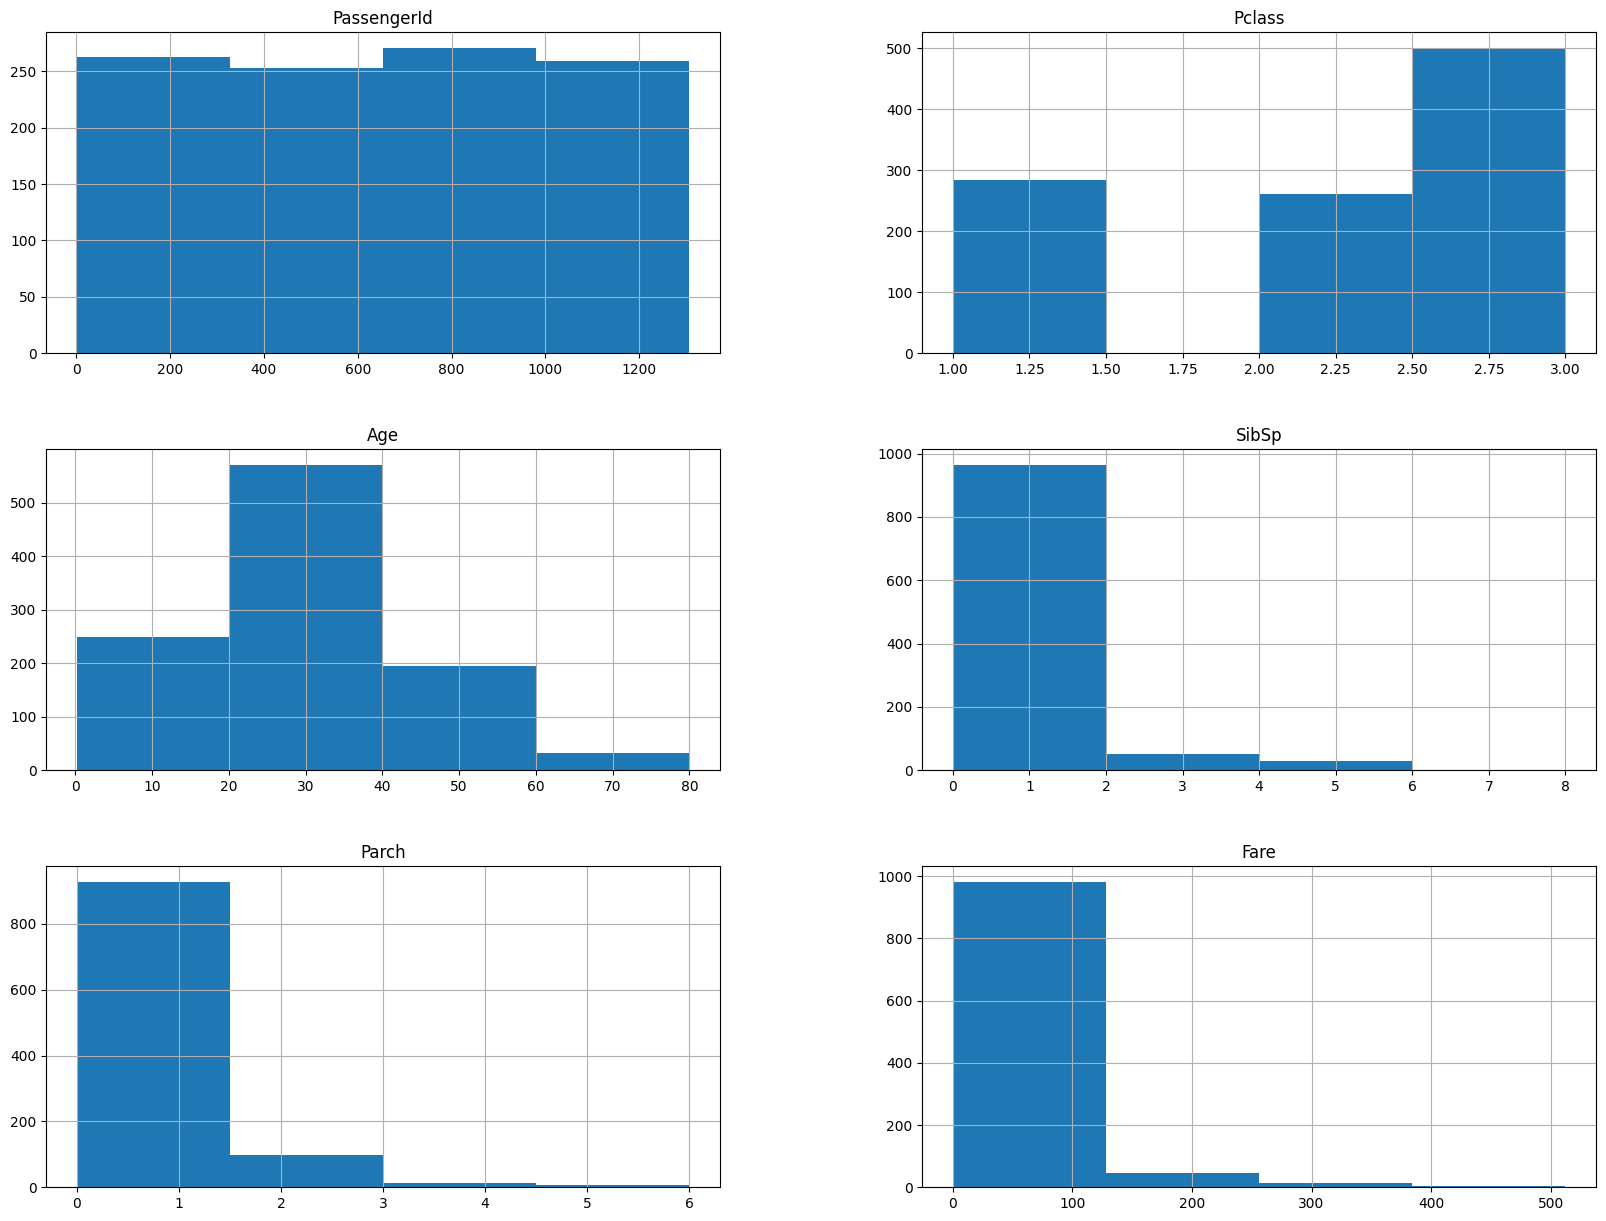

In [ ]:
To_Fit_AGE.hist(bins=4,figsize=(20,15))

In [ ]:
def fill_missing_values(X):
  Y=X.fillna(13.3)
  return Y

def FARE_OUT(K,X):
  return ['Fare_log']

Fare_Filler=FunctionTransformer(fill_missing_values,feature_names_out='one-to-one')

log_transformer=FunctionTransformer(func=np.log1p,feature_names_out=FARE_OUT)


In [ ]:
k=Fare_Filler.fit_transform(To_Fit_AGE[['Fare']])

In [ ]:
k.isnull().sum()

,0
Fare,0


In [ ]:
def extract_title(X):
  k=[]
  for i in range(X.shape[0]):
      Title=re.search(r' ([A-Za-z]+)\.',X.iloc[i,0]).group(1)
      if Title in ['Capt','Col','Don','Dr','Jonkheer','Major','Rev','Sir','Mr','Countess','Dona','Lady','Mrs']:
        k.append('Mr')
      else:
        k.append('Master')
  return np.reshape(np.array(k),(X.shape[0],1))


def title_names(K,X):
  L=[]
  for i in range (len(X)):
     M=f'{X[i]}_title'
     L.append(M)
  return L


Title_Extractor=FunctionTransformer(extract_title,feature_names_out=title_names)

In [ ]:
Title_Pipe=Pipeline(
    [('Title_Extraction',Title_Extractor),
     ('Title_one_hot',OneHotEncoder(sparse_output=False))]
)

In [ ]:
sdfsdf=Title_Pipe.fit_transform(To_Fit_AGE[['Name']])

In [ ]:
sdfsdf.shape

(1046, 2)

In [ ]:
Embarked_Pipe=Pipeline(
    [('embarked_imputation',SimpleImputer(strategy='most_frequent')),
     ('embarked_one_hot',OneHotEncoder(sparse_output=False))]
)

In [ ]:
class SameTicketCount(TransformerMixin, BaseEstimator):
   def __init__(self):
    self.valid=False
   def fit(self,X,Y=None):
    groups=X.groupby('Ticket')
    self.thing=groups['Ticket'].count().sort_values(ascending=True)
    self.valid=True
    return self

   def transform(self,X):
    M=[]
    for i in range(X.shape[0]):
      M.append(self.thing[X.iloc[i,0]])
    return  np.reshape(np.array(M),(X.shape[0],1))

   def get_feature_names_out(self, input_feature=None):
    if input_feature is None:
          input_feature= ["Group_Of"]
    return input_feature



Ticket_GroupCount=SameTicketCount()

In [ ]:
Sex_Encoded=OneHotEncoder(sparse_output=False)

In [ ]:
def ChildrenOrParent(X):
   assert X.shape[1]==1
   Y=[]
   for i in range (X.shape[0]):
      if X.iloc[i,0]>2:
        Y.append(1.0)
      else:
        Y.append(0.0)
   return np.reshape(np.array(Y),(X.shape[0],1))


ChildrenOrParentFUNC=FunctionTransformer(ChildrenOrParent,feature_names_out='one-to-one')

In [ ]:
Pass_Columns=['Pclass','Age','SibSp', 'Parch']

In [ ]:
Col_transofrmer=ColumnTransformer(transformers=[
    ('Fare_filling',Fare_Filler,['Fare']),
    ('Title_Cat',Title_Pipe,['Name']),
    ('Embarked_Cat',Embarked_Pipe,['Embarked']),
    ('Sex_Encoding',Sex_Encoded,['Sex']),
    ('Parch>2_check',ChildrenOrParentFUNC,['Parch']),
    ('Ticket_Group_Count',Ticket_GroupCount,['Ticket']),
    ('passthrough','passthrough',Pass_Columns),
],remainder='drop')

In [ ]:
Col_transofrmer.fit(FullData)

ColumnTransformer(transformers=[('Fare_filling',
                                 FunctionTransformer(feature_names_out='one-to-one',
                                                     func=<function fill_missing_values at 0x7b69fd9725c0>),
                                 ['Fare']),
                                ('Title_Cat',
                                 Pipeline(steps=[('Title_Extraction',
                                                  FunctionTransformer(feature_names_out=<function title_names at 0x7b69fd972e80>,
                                                                      func=<function extract_title at 0x7b69fd972de0>)),
                                                 ('Title_one_hot',...
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Embarked']),
                                ('Sex_Encoding',
                                 OneHotEncoder(sparse_output=False), ['Sex']),
                                ('Parch>2_check',
                                 FunctionTransformer(feature_names_out='one-to-one',
                                                     func=<function ChildrenOrParent at 0x7b69fd9049a0>),
                                 ['Parch']),
                                ('Ticket_Group_Count', SameTicketCount(),
                                 ['Ticket']),
                                ('passthrough', 'passthrough',
                                 ['Pclass', 'Age', 'SibSp', 'Parch'])])

In [ ]:
qsdqsd=Col_transofrmer.transform(To_Fit_AGE)

In [ ]:
Transformed_TRAINSET=pd.DataFrame(data=qsdqsd,
                             columns=  Col_transofrmer.get_feature_names_out()
                             )

In [ ]:
Transformed_TRAINSET.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Fare_filling__Fare            1046 non-null   float64
 1   Title_Cat__Name_title_Master  1046 non-null   float64
 2   Title_Cat__Name_title_Mr      1046 non-null   float64
 3   Embarked_Cat__Embarked_C      1046 non-null   float64
 4   Embarked_Cat__Embarked_Q      1046 non-null   float64
 5   Embarked_Cat__Embarked_S      1046 non-null   float64
 6   Sex_Encoding__Sex_female      1046 non-null   float64
 7   Sex_Encoding__Sex_male        1046 non-null   float64
 8   Parch>2_check__Parch          1046 non-null   float64
 9   Ticket_Group_Count__Ticket    1046 non-null   float64
 10  passthrough__Pclass           1046 non-null   float64
 11  passthrough__Age              1046 non-null   float64
 12  passthrough__SibSp            1046 non-null   float64
 13  pas

In [ ]:
Transformed_TRAINSET['age_cuts']=pd.cut(Transformed_TRAINSET['passthrough__Age'],bins=[0,20,40,60,80],labels=[1,2,3,4])

split=StratifiedShuffleSplit(n_splits=3,test_size=0.1,random_state=42)
strat_splits = []
for train_ID,test_ID in split.split(X=Transformed_TRAINSET,y=Transformed_TRAINSET['age_cuts']):
  strat_train_set=Transformed_TRAINSET.iloc[train_ID]
  strat_test_set=Transformed_TRAINSET.iloc[test_ID]
  strat_splits.append((strat_train_set,strat_test_set))


In [ ]:
Train_Dataset,Test_Dataset=strat_splits[2][0],strat_splits[2][1]

Train_FEATURESS,Train_LABELS=Train_Dataset.drop(['passthrough__Age','age_cuts'],axis=1),Train_Dataset['passthrough__Age']
Test_Features,Test_LABELS=Test_Dataset.drop(['passthrough__Age','age_cuts'],axis=1),Test_Dataset['passthrough__Age']



Full_X=Transformed_TRAINSET.drop(['passthrough__Age','age_cuts'],axis=1)
Full_Y=Transformed_TRAINSET['passthrough__Age']

In [ ]:
#Models

RF_AGE2=RandomForestRegressor(bootstrap=True,max_depth=10,max_features='sqrt',min_samples_leaf=1,min_samples_split=10,n_estimators=100)

In [ ]:
# 'bootstrap':True,'max_depth':10,'max_features':'sqrt','min_samples_leaf':1,'min_samples_split':10,'n_estimators':100

In [ ]:
RF_AGE.fit(Train_FEATURESS,Train_LABELS)
rf_predictions=RF_AGE.predict(Test_Features)

In [ ]:
RF_AGE2.fit(Train_FEATURESS,Train_LABELS)
rf_TUNED_predictions=RF_AGE2.predict(Test_Features)

In [ ]:
rmses2=root_mean_squared_error(Test_LABELS,rf_TUNED_predictions)

In [ ]:
rmses2

10.705373940378097

In [ ]:
score2=r2_score(Test_LABELS,rf_TUNED_predictions)

In [ ]:
score2

0.4064442764178874

In [ ]:
RF_AGE2.fit(Full_X,Full_Y)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10)

In [ ]:
joblib.dump(Col_transofrmer, "Age_Col_transofrmer.joblib")

['Age_Col_transofrmer.joblib']

In [ ]:
joblib.dump(RF_AGE2, "Age_imputer.model")

['Age_imputer.model']